**Importing the required libraries.**

In [2]:
import fastai 
import torch

import pandas as pd #to create the required dataframes
import numpy as np
import seaborn as sns #for plotting
import matplotlib.pyplot as plt #for plotting

from torch import nn, optim, cuda
from torch.utils.data import TensorDataset,DataLoader
from fastai import basic_train, basic_data, train as tr
from fastai import callbacks
from fastai.callbacks import ActivationStats
from fastai.core import ItemBase
from nn_utils import AE_3D_200 #this is the model that we will be using to compress the given data

We are using the AE_3D_200 model to perform data compression. If we want to use any other model, we simply have to import it from the nn_utils module.</br>

These files contain the training and testing data required to train and test our Neural Network.

In [3]:
train_file = "all_jets_train_4D_100_percent.pkl"
test_file = "all_jets_test_4D_100_percent.pkl"

We now load the training and testing dataset into a pandas DataFrame.

In [4]:
train_df = pd.read_pickle(train_file)
test_df = pd.read_pickle(test_file)
print("Training Dataset")
display(train_df.head())
print("\n\nTest Dataset")
display(test_df.head())

Training Dataset


,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871




Test Dataset


,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069


To make our neural network train faster on these datasets, we normalize both the training.</br>

Since this model works on normalized training data, the test data needs to be normalized as well.

In [5]:
train_mean = train_df.mean()
train_std = train_df.std()

train = (train_df-train_mean)/train_std
test = (test_df-train_mean)/train_std

train.head()

,m,pt,phi,eta
132784,-0.688496,-0.607629,0.868107,0.759040
99666,-0.587358,-0.612672,-1.487534,0.117474
26629,1.051897,1.503479,-1.081401,0.773105
80473,0.788036,1.697702,-0.911068,1.813972
48229,-0.578692,-0.628716,1.619709,-0.830115


**Since we are building an autoencoder, the output should be equal to the input (as we reconstruct the encoded data), therefore, we have train_x = train_y.</br>**

In [6]:
train_x = train
train_y = train

test_x = test
test_y = test

train_ds = TensorDataset(torch.FloatTensor(train_x.values),torch.FloatTensor(train_y.values))
validation_ds = TensorDataset(torch.FloatTensor(test_x.values),torch.FloatTensor(test_y.values))

We now create a helper function which helps us to divide our training dataset and validation dataset into batches of size bs.

In [7]:
def get_data(train_ds,val_ds,bs=256):
    return (DataLoader(train_ds,batch_size=bs,shuffle = True),
           DataLoader(val_ds,batch_size = bs))

In [8]:
train_dl,validation_dl = get_data(train_ds,validation_ds)

In [9]:
db = basic_data.DataBunch(train_dl,validation_dl)

The model to be used for this task is defined here. 

In [10]:
model = AE_3D_200()

Following are some plots of the variables of the given dataset which helps us to visualize the data better.</br></br>

To plot these graphs, a subset of the original dataset is taken.

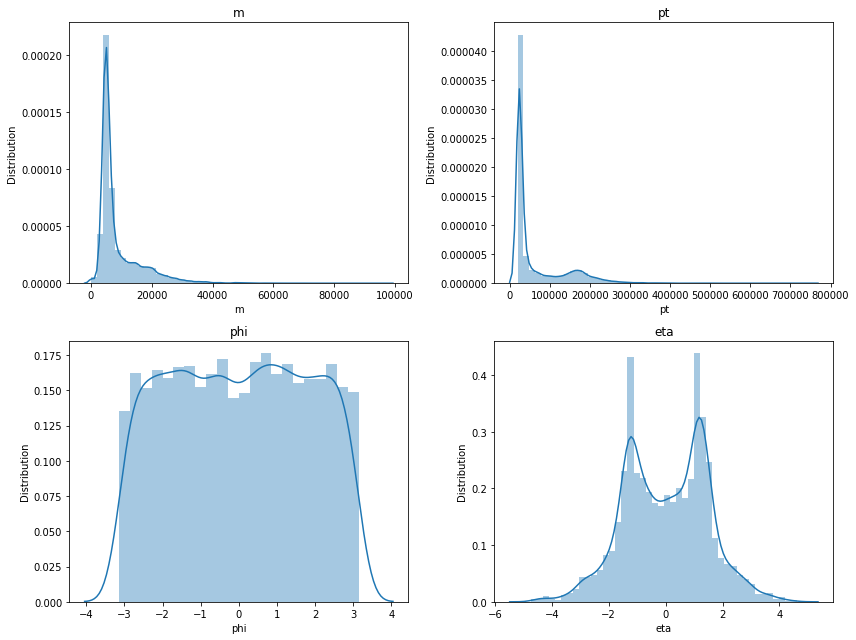

In [11]:
plot_df = pd.read_pickle(train_file).sample(10000) #we sample 10000 datapoints from the train dataframe

fig,axes = plt.subplots(nrows = 2,ncols = 2,figsize = (12,9))

i = 0
for Ax in axes.flatten():
    g = sns.distplot(plot_df.loc[:,plot_df.columns[i]],ax = Ax)
    g.set_title(plot_df.columns[i])
    i = i+1
    g.set_ylabel("Distribution")

g = plt.tight_layout() #this makes sure that the labels of different plots do not overlap

The following heat map is drawn to show the extent of correlation between the different variables.</br>

From this heatmap, we can see that there is a very high correlation between m and pt.

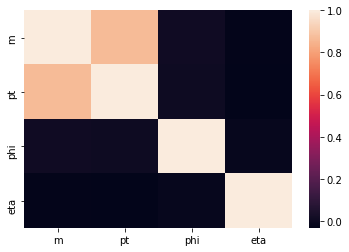

In [12]:
sns.heatmap(plot_df.corr())

**Building and training the autoencoder.**

In [13]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()
#We use root mean squared error as our loss function.

To find the optimal learning rate, we use the basic_train.learner method of the fastai library.</br>



In [14]:
bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [15]:
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


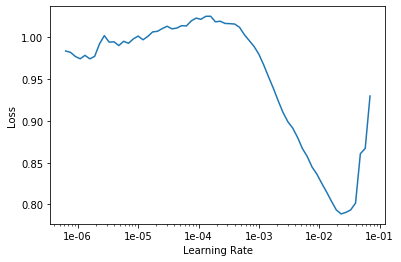

In [16]:
learn.recorder.plot()

We now use various learning rate values to train our model and tabulate the training and validation errors as well as plot the validation errors.</br>

To find the optimal learning rate, we find the point on the curve with the steepest downward slope that still has a high value.</br>

This value is stored in min_grad_lr.

Min numerical gradient: 2.09E-03
Min loss divided by 10: 2.29E-03


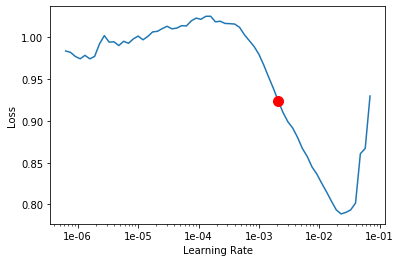

In [17]:
learn.recorder.plot(suggestion = True)
min_grad_lr = learn.recorder.min_grad_lr

We now iterate over 3 different Learning Rates , tabulate the training and validation losses and also plot these for  each entry in our dataset.</br>

If a metric stops improving, we reduce the Learning Rate by a factor of 5. We check these metrics after every 4 epochs.

Initial Learning Rate: 0.0001


epoch,train_loss,valid_loss,time
0,0.053887,0.051811,00:25
1,0.033144,0.037606,00:20
2,0.033686,0.035427,00:21
3,0.032428,0.034528,00:21
4,0.032404,0.034034,00:21
5,0.032761,0.033462,00:21
6,0.031310,0.032976,00:21
7,0.030720,0.032344,00:21
8,0.030395,0.031724,00:21
9,0.030890,0.031487,00:21


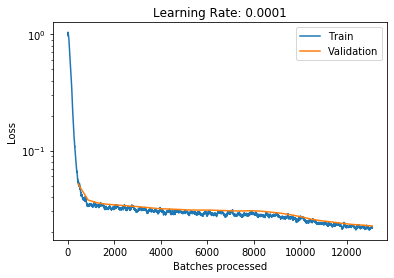

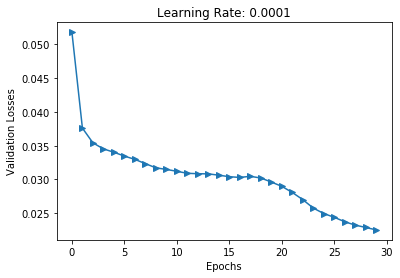

Initial Learning Rate: 0.0020892961308540407


epoch,train_loss,valid_loss,time
0,0.023057,0.025744,00:22
1,0.022246,0.023404,00:21
2,0.021845,0.021399,00:21
3,0.020481,0.023959,00:20
4,0.020325,0.018722,00:20
5,0.019275,0.019301,00:21
6,0.017789,0.017437,00:21
7,0.022546,0.020756,00:21
8,0.019948,0.018090,00:24
9,0.018910,0.024417,00:22


Epoch 10: reducing lr to 0.0004178592261708082


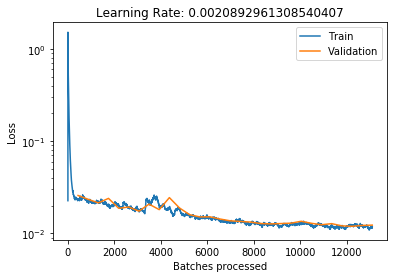

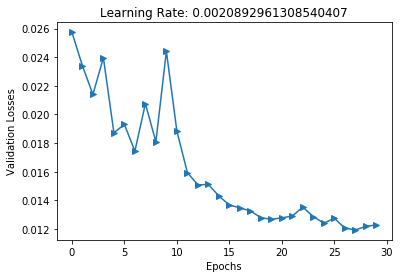

Initial Learning Rate: 0.001


epoch,train_loss,valid_loss,time
0,0.012641,0.013307,00:23
1,0.013111,0.013369,00:25
2,0.012047,0.012108,00:20
3,0.012347,0.012676,00:30
4,0.011960,0.011773,00:23
5,0.012170,0.012829,00:26
6,0.013003,0.013609,00:21
7,0.011266,0.012149,00:20
8,0.013276,0.013068,00:20
9,0.012834,0.013880,00:21


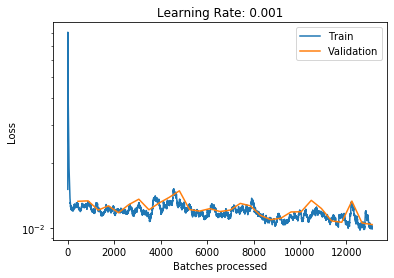

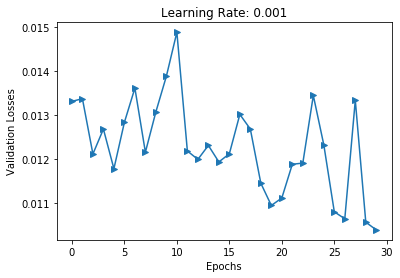

<Figure size 432x288 with 0 Axes>

In [18]:
lrs = [0.0001,min_grad_lr,0.001]

min_loss = float(1e9) #stores the minimum validation loss over the list lrs
opt_lr = min_grad_lr #stores the optimal lr that we get after we train our model on the list lrs

for ind,LR in enumerate(lrs):
    print("Initial Learning Rate: {}".format(LR))
    learn = basic_train.Learner(data = db, model = model, loss_func = loss_func, wd =wd, callback_fns = ActivationStats, bn_wd = bn_wd, true_wd = true_wd)
    learn.fit(epochs = 30, lr = LR, wd = wd,callbacks = callbacks.ReduceLROnPlateauCallback(learn = learn, factor = 0.2, patience = 3))
    learn.recorder.plot_losses()
    plt.yscale('log')
    plt.title('Learning Rate: {}'.format(LR))
    plt.show()
    plt.plot(learn.recorder.val_losses,marker = '>')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Losses')
    plt.title('Learning Rate: {}'.format(LR))
    plt.show()
    if(learn.recorder.val_losses[-1]<min_loss):# if we get a learning rate which gives us a lesser validation loss than we currently have, we update our lr to be this value
        min_loss = learn.recorder.val_losses[-1]
        opt_lr = LR
plt.tight_layout()

Now, using this optimum learning rate, we train and save the model as the final model that we will be using.

In [19]:
    learn = basic_train.Learner(data = db, model = model, loss_func = loss_func, wd =wd, callback_fns = ActivationStats, bn_wd = bn_wd, true_wd = true_wd)
    learn.fit(epochs = 30, lr = opt_lr, wd = wd,callbacks = callbacks.ReduceLROnPlateauCallback(learn = learn, factor = 0.2, patience = 3))
    learn.save('AE_3D_200_final_model')

epoch,train_loss,valid_loss,time
0,0.010481,0.010917,00:24
1,0.011383,0.011975,00:32
2,0.012253,0.013573,00:21
3,0.011768,0.011462,00:21
4,0.013260,0.013149,00:21
5,0.011815,0.012388,00:21
6,0.011959,0.012293,00:21
7,0.011377,0.011939,00:21
8,0.016677,0.015756,00:21
9,0.014403,0.015920,00:21


In [20]:
learn.load('AE_3D_200_final_model')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x0000026A22EE1348>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x0000026A1BAC4308>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=WindowsPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_t

Now that we have our model, we can test it out on the validation dataset.</br>

test_x and test_y store our normalized test input and output respectively.

In [21]:
idx = (0,100000)
data = torch.FloatTensor(test_x[idx[0]:idx[1]].values)
# since the data is normalized, we denormalize it here to see how the data has been reconstructed.
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values) #pred stores the normalized reconstructed data
pred = np.add(pred, train_mean.values)#we multiply by train_std.values and add train_mean.values to pred to get back the reconstructed data that is not normalized
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values) #this step stores the original test data in data

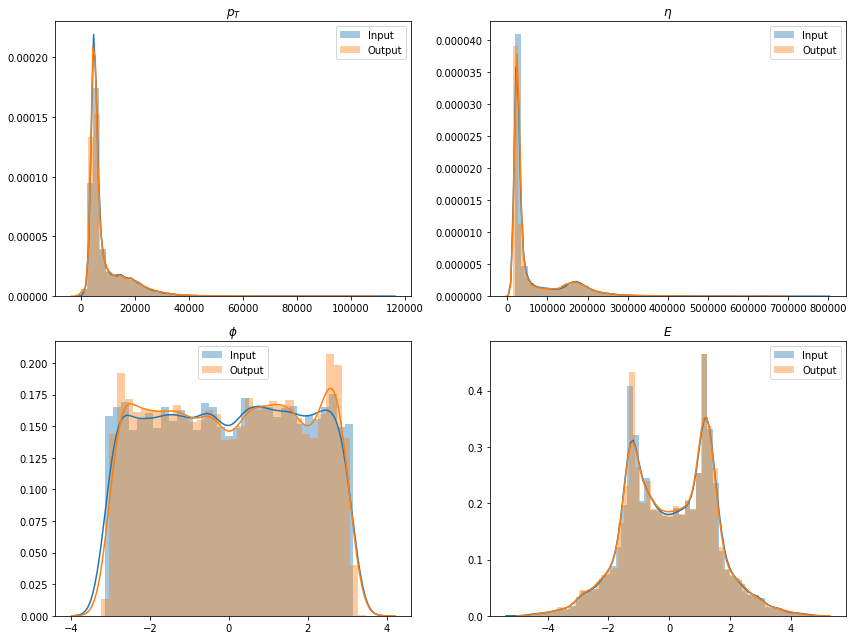

In [22]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,9))
plot_titles =  [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
for ind,axis in enumerate(ax.flatten()):
    g = sns.distplot(data[:,ind],label = 'Input',ax = axis)
    g = sns.distplot(pred[:,ind],label = 'Output',ax = axis)
    g.set_title('{}'.format(plot_titles[ind]))
    g= g.legend()
plt.tight_layout()

The above plots show us that the model has reconstructed the original data with minimal loss.</br>

**Thus our autoencoder is able to encode and decode the original data with very little loss.**

**The difference between the original and reconstructed data divided by the original data (residual plots) for various features of the dataset are given below.**

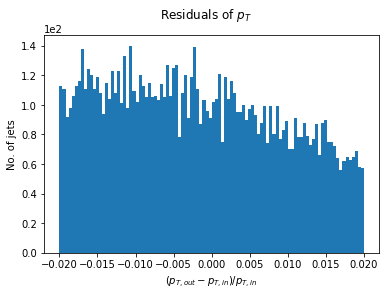

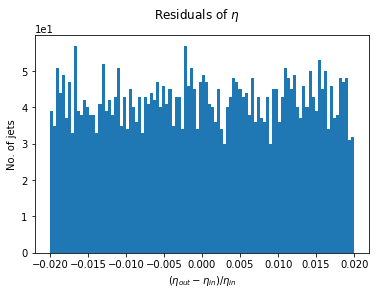

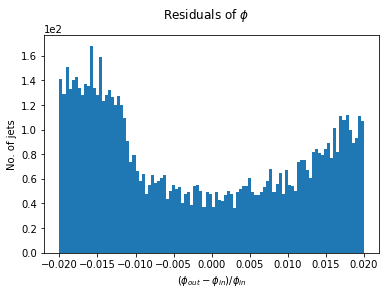

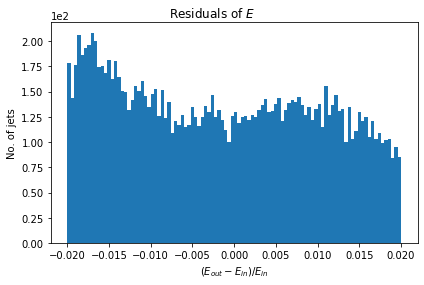

In [26]:
residual = (pred - data.detach().numpy())/data.detach().numpy()
range = (-0.02,0.02)
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']

for ind in np.arange(4):
    plt.figure()
    plt.hist(residual[:,ind],bins = 100,range = range)
    plt.suptitle("Residuals of {}".format(plot_titles[ind]))
    plt.xlabel(residual_strings[ind])
    plt.ylabel("No. of jets")
    plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
plt.tight_layout()